# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*0.01
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        w=self.scaleLayer(w)
        if a>0.37:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.349797, Accuracy: 10.55
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.427861, Accuracy: 10.16
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.387897, Accuracy: 10.16
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.369787, Accuracy: 10.94
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.273211, Accuracy: 10.55
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.170273, Accuracy: 14.84
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.114117, Accuracy: 16.80
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.064619, Accuracy: 18.36
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.072523, Accuracy: 18.36
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.092335, Accuracy: 17.97
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.055522, Accuracy: 17.58
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.020588, Accuracy: 19.92
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.999772, Accuracy: 19.53
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.992476, Accuracy: 21.09
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.971495, Accuracy: 19.14
Train Epoc

Train Epoch: 1 [32000/50000 (71%)]	Loss: 1.734736, Accuracy: 31.25
Train Epoch: 1 [33280/50000 (74%)]	Loss: 1.664441, Accuracy: 36.72
Train Epoch: 1 [34560/50000 (77%)]	Loss: 1.549440, Accuracy: 40.23
Train Epoch: 1 [35840/50000 (80%)]	Loss: 1.553802, Accuracy: 39.45
Train Epoch: 1 [37120/50000 (82%)]	Loss: 1.530834, Accuracy: 39.45
Train Epoch: 1 [38400/50000 (85%)]	Loss: 1.568541, Accuracy: 38.28
Train Epoch: 1 [39680/50000 (88%)]	Loss: 1.498329, Accuracy: 43.75
Train Epoch: 1 [40960/50000 (91%)]	Loss: 1.594567, Accuracy: 41.02
Train Epoch: 1 [42240/50000 (94%)]	Loss: 1.385709, Accuracy: 51.17
Train Epoch: 1 [43520/50000 (97%)]	Loss: 1.527380, Accuracy: 42.19
Train Epoch: 1 [35000/50000 (99%)]	Loss: 1.411642, Accuracy: 43.50

Validation set: Average loss: 1.7329, Accuracy: 1675/5000 (33.00%)

the time of this epoch:[36.68057107925415 s]
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.576696, Accuracy: 38.28
Train Epoch: 2 [1280/50000 (3%)]	Loss: 1.485290, Accuracy: 39.84
Train Epoch: 2 [2560/5

Train Epoch: 4 [35000/50000 (99%)]	Loss: 0.954569, Accuracy: 62.00

Validation set: Average loss: 1.0993, Accuracy: 3063/5000 (61.00%)

the time of this epoch:[36.5317702293396 s]
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.839592, Accuracy: 71.48
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.992993, Accuracy: 67.97
Train Epoch: 5 [2560/50000 (6%)]	Loss: 0.843906, Accuracy: 72.66
Train Epoch: 5 [3840/50000 (9%)]	Loss: 0.820828, Accuracy: 70.31
Train Epoch: 5 [5120/50000 (11%)]	Loss: 0.907410, Accuracy: 69.14
Train Epoch: 5 [6400/50000 (14%)]	Loss: 0.982285, Accuracy: 64.45
Train Epoch: 5 [7680/50000 (17%)]	Loss: 1.035312, Accuracy: 65.23
Train Epoch: 5 [8960/50000 (20%)]	Loss: 0.922567, Accuracy: 67.97
Train Epoch: 5 [10240/50000 (23%)]	Loss: 0.860792, Accuracy: 71.09
Train Epoch: 5 [11520/50000 (26%)]	Loss: 1.087706, Accuracy: 62.50
Train Epoch: 5 [12800/50000 (28%)]	Loss: 0.944135, Accuracy: 64.06
Train Epoch: 5 [14080/50000 (31%)]	Loss: 1.106765, Accuracy: 57.03
Train Epoch: 5 [15360/50000 (34

Train Epoch: 6 [7680/50000 (17%)]	Loss: 0.853471, Accuracy: 67.97
Train Epoch: 6 [8960/50000 (20%)]	Loss: 0.786076, Accuracy: 70.70
Train Epoch: 6 [10240/50000 (23%)]	Loss: 0.867586, Accuracy: 72.66
Train Epoch: 6 [11520/50000 (26%)]	Loss: 0.895585, Accuracy: 67.58
Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.835924, Accuracy: 69.53
Train Epoch: 6 [14080/50000 (31%)]	Loss: 0.783279, Accuracy: 73.83
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.904097, Accuracy: 68.36
Train Epoch: 6 [16640/50000 (37%)]	Loss: 0.643172, Accuracy: 78.52
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.810211, Accuracy: 73.05
Train Epoch: 6 [19200/50000 (43%)]	Loss: 0.803985, Accuracy: 73.05
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.799539, Accuracy: 71.48
Train Epoch: 6 [21760/50000 (48%)]	Loss: 0.783305, Accuracy: 71.09
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.814216, Accuracy: 68.75
Train Epoch: 6 [24320/50000 (54%)]	Loss: 0.785953, Accuracy: 74.61
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.755920, Accuracy: 75.

Train Epoch: 9 [20480/50000 (45%)]	Loss: 0.640176, Accuracy: 76.56
Train Epoch: 9 [21760/50000 (48%)]	Loss: 0.583490, Accuracy: 79.30
Train Epoch: 9 [23040/50000 (51%)]	Loss: 0.556433, Accuracy: 78.52
Train Epoch: 9 [24320/50000 (54%)]	Loss: 0.648202, Accuracy: 76.56
Train Epoch: 9 [25600/50000 (57%)]	Loss: 0.710102, Accuracy: 76.56
Train Epoch: 9 [26880/50000 (60%)]	Loss: 0.679709, Accuracy: 74.22
Train Epoch: 9 [28160/50000 (62%)]	Loss: 0.677625, Accuracy: 79.69
Train Epoch: 9 [29440/50000 (65%)]	Loss: 0.593843, Accuracy: 78.12
Train Epoch: 9 [30720/50000 (68%)]	Loss: 0.715258, Accuracy: 73.83
Train Epoch: 9 [32000/50000 (71%)]	Loss: 0.701416, Accuracy: 75.78
Train Epoch: 9 [33280/50000 (74%)]	Loss: 0.634429, Accuracy: 78.12
Train Epoch: 9 [34560/50000 (77%)]	Loss: 0.711598, Accuracy: 75.39
Train Epoch: 9 [35840/50000 (80%)]	Loss: 0.517532, Accuracy: 82.03
Train Epoch: 9 [37120/50000 (82%)]	Loss: 0.654124, Accuracy: 77.73
Train Epoch: 9 [38400/50000 (85%)]	Loss: 0.797662, Accuracy: 7

Train Epoch: 11 [26880/50000 (60%)]	Loss: 0.548735, Accuracy: 82.42
Train Epoch: 11 [28160/50000 (62%)]	Loss: 0.504482, Accuracy: 81.64
Train Epoch: 11 [29440/50000 (65%)]	Loss: 0.579207, Accuracy: 79.30
Train Epoch: 11 [30720/50000 (68%)]	Loss: 0.695621, Accuracy: 78.52
Train Epoch: 11 [32000/50000 (71%)]	Loss: 0.718611, Accuracy: 78.12
Train Epoch: 11 [33280/50000 (74%)]	Loss: 0.507222, Accuracy: 82.42
Train Epoch: 11 [34560/50000 (77%)]	Loss: 0.594518, Accuracy: 79.69
Train Epoch: 11 [35840/50000 (80%)]	Loss: 0.672179, Accuracy: 79.69
Train Epoch: 11 [37120/50000 (82%)]	Loss: 0.655426, Accuracy: 79.30
Train Epoch: 11 [38400/50000 (85%)]	Loss: 0.549038, Accuracy: 83.98
Train Epoch: 11 [39680/50000 (88%)]	Loss: 0.670537, Accuracy: 78.52
Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.661698, Accuracy: 78.12
Train Epoch: 11 [42240/50000 (94%)]	Loss: 0.495776, Accuracy: 81.25
Train Epoch: 11 [43520/50000 (97%)]	Loss: 0.573045, Accuracy: 79.30
Train Epoch: 11 [35000/50000 (99%)]	Loss: 0.6438

Train Epoch: 14 [21760/50000 (48%)]	Loss: 0.400741, Accuracy: 86.72
Train Epoch: 14 [23040/50000 (51%)]	Loss: 0.473347, Accuracy: 84.38
Train Epoch: 14 [24320/50000 (54%)]	Loss: 0.653402, Accuracy: 78.52
Train Epoch: 14 [25600/50000 (57%)]	Loss: 0.571284, Accuracy: 81.64
Train Epoch: 14 [26880/50000 (60%)]	Loss: 0.552825, Accuracy: 82.03
Train Epoch: 14 [28160/50000 (62%)]	Loss: 0.492576, Accuracy: 83.59
Train Epoch: 14 [29440/50000 (65%)]	Loss: 0.511489, Accuracy: 82.42
Train Epoch: 14 [30720/50000 (68%)]	Loss: 0.577049, Accuracy: 80.47
Train Epoch: 14 [32000/50000 (71%)]	Loss: 0.497360, Accuracy: 83.20
Train Epoch: 14 [33280/50000 (74%)]	Loss: 0.488395, Accuracy: 82.42
Train Epoch: 14 [34560/50000 (77%)]	Loss: 0.577261, Accuracy: 78.52
Train Epoch: 14 [35840/50000 (80%)]	Loss: 0.612044, Accuracy: 81.25
Train Epoch: 14 [37120/50000 (82%)]	Loss: 0.593552, Accuracy: 80.47
Train Epoch: 14 [38400/50000 (85%)]	Loss: 0.623874, Accuracy: 80.08
Train Epoch: 14 [39680/50000 (88%)]	Loss: 0.5534

Train Epoch: 17 [12800/50000 (28%)]	Loss: 0.521646, Accuracy: 82.42
Train Epoch: 17 [14080/50000 (31%)]	Loss: 0.545255, Accuracy: 78.91
Train Epoch: 17 [15360/50000 (34%)]	Loss: 0.421317, Accuracy: 83.98
Train Epoch: 17 [16640/50000 (37%)]	Loss: 0.530051, Accuracy: 84.77
Train Epoch: 17 [17920/50000 (40%)]	Loss: 0.461007, Accuracy: 85.16
Train Epoch: 17 [19200/50000 (43%)]	Loss: 0.467845, Accuracy: 82.03
Train Epoch: 17 [20480/50000 (45%)]	Loss: 0.387237, Accuracy: 88.67
Train Epoch: 17 [21760/50000 (48%)]	Loss: 0.487414, Accuracy: 85.55
Train Epoch: 17 [23040/50000 (51%)]	Loss: 0.447121, Accuracy: 86.33
Train Epoch: 17 [24320/50000 (54%)]	Loss: 0.500024, Accuracy: 83.59
Train Epoch: 17 [25600/50000 (57%)]	Loss: 0.494386, Accuracy: 83.59
Train Epoch: 17 [26880/50000 (60%)]	Loss: 0.401652, Accuracy: 85.94
Train Epoch: 17 [28160/50000 (62%)]	Loss: 0.437260, Accuracy: 85.55
Train Epoch: 17 [29440/50000 (65%)]	Loss: 0.413359, Accuracy: 85.94
Train Epoch: 17 [30720/50000 (68%)]	Loss: 0.4544

Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.545777, Accuracy: 81.25
Train Epoch: 18 [35000/50000 (99%)]	Loss: 0.552603, Accuracy: 77.00

Validation set: Average loss: 0.6367, Accuracy: 3949/5000 (78.00%)

the time of this epoch:[36.70238184928894 s]

Test set: Average loss: 0.6737, Accuracy: 7736/10000 (77.36%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.391572, Accuracy: 86.33
Train Epoch: 19 [1280/50000 (3%)]	Loss: 0.517755, Accuracy: 83.59
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.474267, Accuracy: 83.98
Train Epoch: 19 [3840/50000 (9%)]	Loss: 0.389957, Accuracy: 85.94
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.589827, Accuracy: 80.08
Train Epoch: 19 [6400/50000 (14%)]	Loss: 0.413600, Accuracy: 85.94
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.482798, Accuracy: 86.33
Train Epoch: 19 [8960/50000 (20%)]	Loss: 0.571211, Accuracy: 81.25
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.512940, Accuracy: 84.77
Train Epoch: 19 [11520/50000 (26%)]	Loss: 0.468934, Accuracy: 82.03
Train Epoch: 19 [1280

Train Epoch: 22 [3840/50000 (9%)]	Loss: 0.373824, Accuracy: 88.28
Train Epoch: 22 [5120/50000 (11%)]	Loss: 0.454342, Accuracy: 82.42
Train Epoch: 22 [6400/50000 (14%)]	Loss: 0.476573, Accuracy: 82.81
Train Epoch: 22 [7680/50000 (17%)]	Loss: 0.557757, Accuracy: 82.81
Train Epoch: 22 [8960/50000 (20%)]	Loss: 0.417765, Accuracy: 88.28
Train Epoch: 22 [10240/50000 (23%)]	Loss: 0.598036, Accuracy: 78.91
Train Epoch: 22 [11520/50000 (26%)]	Loss: 0.484875, Accuracy: 82.81
Train Epoch: 22 [12800/50000 (28%)]	Loss: 0.385744, Accuracy: 86.72
Train Epoch: 22 [14080/50000 (31%)]	Loss: 0.510925, Accuracy: 81.64
Train Epoch: 22 [15360/50000 (34%)]	Loss: 0.509993, Accuracy: 82.81
Train Epoch: 22 [16640/50000 (37%)]	Loss: 0.421148, Accuracy: 86.72
Train Epoch: 22 [17920/50000 (40%)]	Loss: 0.416075, Accuracy: 84.77
Train Epoch: 22 [19200/50000 (43%)]	Loss: 0.449593, Accuracy: 85.16
Train Epoch: 22 [20480/50000 (45%)]	Loss: 0.538947, Accuracy: 81.25
Train Epoch: 22 [21760/50000 (48%)]	Loss: 0.421244, Ac

Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.455102, Accuracy: 83.20
Train Epoch: 25 [14080/50000 (31%)]	Loss: 0.458435, Accuracy: 83.98
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.435452, Accuracy: 86.72
Train Epoch: 25 [16640/50000 (37%)]	Loss: 0.516277, Accuracy: 81.25
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.378048, Accuracy: 87.89
Train Epoch: 25 [19200/50000 (43%)]	Loss: 0.512185, Accuracy: 82.42
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.431549, Accuracy: 84.77
Train Epoch: 25 [21760/50000 (48%)]	Loss: 0.336734, Accuracy: 89.06
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.429312, Accuracy: 86.72
Train Epoch: 25 [24320/50000 (54%)]	Loss: 0.516824, Accuracy: 80.08
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.396530, Accuracy: 85.94
Train Epoch: 25 [26880/50000 (60%)]	Loss: 0.400242, Accuracy: 87.50
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.389234, Accuracy: 83.59
Train Epoch: 25 [29440/50000 (65%)]	Loss: 0.480249, Accuracy: 84.38
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.4289

Train Epoch: 28 [23040/50000 (51%)]	Loss: 0.330143, Accuracy: 89.45
Train Epoch: 28 [24320/50000 (54%)]	Loss: 0.494949, Accuracy: 82.03
Train Epoch: 28 [25600/50000 (57%)]	Loss: 0.441937, Accuracy: 83.98
Train Epoch: 28 [26880/50000 (60%)]	Loss: 0.424256, Accuracy: 84.77
Train Epoch: 28 [28160/50000 (62%)]	Loss: 0.539483, Accuracy: 83.59
Train Epoch: 28 [29440/50000 (65%)]	Loss: 0.511110, Accuracy: 82.03
Train Epoch: 28 [30720/50000 (68%)]	Loss: 0.446513, Accuracy: 84.38
Train Epoch: 28 [32000/50000 (71%)]	Loss: 0.327576, Accuracy: 88.67
Train Epoch: 28 [33280/50000 (74%)]	Loss: 0.450954, Accuracy: 85.94
Train Epoch: 28 [34560/50000 (77%)]	Loss: 0.401237, Accuracy: 86.33
Train Epoch: 28 [35840/50000 (80%)]	Loss: 0.382089, Accuracy: 87.11
Train Epoch: 28 [37120/50000 (82%)]	Loss: 0.457628, Accuracy: 84.38
Train Epoch: 28 [38400/50000 (85%)]	Loss: 0.437292, Accuracy: 84.77
Train Epoch: 28 [39680/50000 (88%)]	Loss: 0.469256, Accuracy: 84.77
Train Epoch: 28 [40960/50000 (91%)]	Loss: 0.4201

Train Epoch: 31 [32000/50000 (71%)]	Loss: 0.311011, Accuracy: 88.67
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.387078, Accuracy: 85.55
Train Epoch: 31 [34560/50000 (77%)]	Loss: 0.482676, Accuracy: 83.98
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.507094, Accuracy: 83.59
Train Epoch: 31 [37120/50000 (82%)]	Loss: 0.516079, Accuracy: 82.81
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.317786, Accuracy: 86.72
Train Epoch: 31 [39680/50000 (88%)]	Loss: 0.482302, Accuracy: 84.77
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.465690, Accuracy: 84.38
Train Epoch: 31 [42240/50000 (94%)]	Loss: 0.528847, Accuracy: 81.25
Train Epoch: 31 [43520/50000 (97%)]	Loss: 0.464666, Accuracy: 85.94
Train Epoch: 31 [35000/50000 (99%)]	Loss: 0.323450, Accuracy: 90.00

Validation set: Average loss: 0.4955, Accuracy: 4133/5000 (82.00%)

the time of this epoch:[39.57616972923279 s]
Train Epoch: 32 [0/50000 (0%)]	Loss: 0.418727, Accuracy: 85.94
Train Epoch: 32 [1280/50000 (3%)]	Loss: 0.431935, Accuracy: 84.38
Train Epo

Train Epoch: 34 [42240/50000 (94%)]	Loss: 0.430979, Accuracy: 85.55
Train Epoch: 34 [43520/50000 (97%)]	Loss: 0.415421, Accuracy: 89.06
Train Epoch: 34 [35000/50000 (99%)]	Loss: 0.480545, Accuracy: 84.50

Validation set: Average loss: 0.8230, Accuracy: 3774/5000 (75.00%)

the time of this epoch:[36.73848080635071 s]

Test set: Average loss: 0.8568, Accuracy: 7530/10000 (75.30%)

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.522874, Accuracy: 83.98
Train Epoch: 35 [1280/50000 (3%)]	Loss: 0.365847, Accuracy: 87.89
Train Epoch: 35 [2560/50000 (6%)]	Loss: 0.445184, Accuracy: 84.38
Train Epoch: 35 [3840/50000 (9%)]	Loss: 0.378724, Accuracy: 87.50
Train Epoch: 35 [5120/50000 (11%)]	Loss: 0.412283, Accuracy: 88.67
Train Epoch: 35 [6400/50000 (14%)]	Loss: 0.351186, Accuracy: 87.89
Train Epoch: 35 [7680/50000 (17%)]	Loss: 0.386216, Accuracy: 85.16
Train Epoch: 35 [8960/50000 (20%)]	Loss: 0.390505, Accuracy: 85.94
Train Epoch: 35 [10240/50000 (23%)]	Loss: 0.463295, Accuracy: 84.38
Train Epoch: 35 [1152

Train Epoch: 38 [2560/50000 (6%)]	Loss: 0.285082, Accuracy: 91.02
Train Epoch: 38 [3840/50000 (9%)]	Loss: 0.345884, Accuracy: 87.89
Train Epoch: 38 [5120/50000 (11%)]	Loss: 0.425545, Accuracy: 88.28
Train Epoch: 38 [6400/50000 (14%)]	Loss: 0.335287, Accuracy: 89.84
Train Epoch: 38 [7680/50000 (17%)]	Loss: 0.400653, Accuracy: 86.72
Train Epoch: 38 [8960/50000 (20%)]	Loss: 0.473608, Accuracy: 83.20
Train Epoch: 38 [10240/50000 (23%)]	Loss: 0.281901, Accuracy: 89.84
Train Epoch: 38 [11520/50000 (26%)]	Loss: 0.340918, Accuracy: 87.50
Train Epoch: 38 [12800/50000 (28%)]	Loss: 0.388493, Accuracy: 86.33
Train Epoch: 38 [14080/50000 (31%)]	Loss: 0.490288, Accuracy: 84.38
Train Epoch: 38 [15360/50000 (34%)]	Loss: 0.487639, Accuracy: 83.98
Train Epoch: 38 [16640/50000 (37%)]	Loss: 0.417625, Accuracy: 85.94
Train Epoch: 38 [17920/50000 (40%)]	Loss: 0.329663, Accuracy: 89.06
Train Epoch: 38 [19200/50000 (43%)]	Loss: 0.373466, Accuracy: 88.67
Train Epoch: 38 [20480/50000 (45%)]	Loss: 0.423581, Accu

Train Epoch: 38 [37120/50000 (82%)]	Loss: 0.340754, Accuracy: 89.06
Train Epoch: 38 [38400/50000 (85%)]	Loss: 0.352340, Accuracy: 87.11
Train Epoch: 38 [39680/50000 (88%)]	Loss: 0.341898, Accuracy: 88.67
Train Epoch: 38 [40960/50000 (91%)]	Loss: 0.369775, Accuracy: 88.67
Train Epoch: 38 [42240/50000 (94%)]	Loss: 0.473812, Accuracy: 83.59
Train Epoch: 38 [43520/50000 (97%)]	Loss: 0.382252, Accuracy: 87.50
Train Epoch: 38 [35000/50000 (99%)]	Loss: 0.396435, Accuracy: 88.50

Validation set: Average loss: 0.4625, Accuracy: 4245/5000 (84.00%)

the time of this epoch:[36.22454333305359 s]

Test set: Average loss: 0.4669, Accuracy: 8397/10000 (83.97%)

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.366376, Accuracy: 88.28
Train Epoch: 39 [1280/50000 (3%)]	Loss: 0.392366, Accuracy: 87.50
Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.354865, Accuracy: 88.67
Train Epoch: 39 [3840/50000 (9%)]	Loss: 0.341388, Accuracy: 90.23
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.389149, Accuracy: 87.11
Train Epoch: 39 [6

Train Epoch: 40 [40960/50000 (91%)]	Loss: 0.402501, Accuracy: 87.50
Train Epoch: 40 [42240/50000 (94%)]	Loss: 0.395474, Accuracy: 84.77
Train Epoch: 40 [43520/50000 (97%)]	Loss: 0.426699, Accuracy: 84.77
Train Epoch: 40 [35000/50000 (99%)]	Loss: 0.390871, Accuracy: 86.50

Validation set: Average loss: 0.8207, Accuracy: 3731/5000 (74.00%)

the time of this epoch:[36.13926839828491 s]

Test set: Average loss: 0.8509, Accuracy: 7344/10000 (73.44%)

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.361202, Accuracy: 85.94
Train Epoch: 41 [1280/50000 (3%)]	Loss: 0.361932, Accuracy: 88.67
Train Epoch: 41 [2560/50000 (6%)]	Loss: 0.337414, Accuracy: 89.06
Train Epoch: 41 [3840/50000 (9%)]	Loss: 0.414634, Accuracy: 86.72
Train Epoch: 41 [5120/50000 (11%)]	Loss: 0.423485, Accuracy: 85.94
Train Epoch: 41 [6400/50000 (14%)]	Loss: 0.358962, Accuracy: 87.50
Train Epoch: 41 [7680/50000 (17%)]	Loss: 0.375701, Accuracy: 87.50
Train Epoch: 41 [8960/50000 (20%)]	Loss: 0.357073, Accuracy: 88.67
Train Epoch: 41 [1024

Train Epoch: 43 [34560/50000 (77%)]	Loss: 0.394820, Accuracy: 87.50
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.370896, Accuracy: 88.28
Train Epoch: 43 [37120/50000 (82%)]	Loss: 0.389093, Accuracy: 86.72
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.476099, Accuracy: 82.81
Train Epoch: 43 [39680/50000 (88%)]	Loss: 0.465977, Accuracy: 80.47
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.350358, Accuracy: 85.94
Train Epoch: 43 [42240/50000 (94%)]	Loss: 0.420243, Accuracy: 87.50
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.382221, Accuracy: 87.50
Train Epoch: 43 [35000/50000 (99%)]	Loss: 0.478369, Accuracy: 88.00

Validation set: Average loss: 0.7280, Accuracy: 3853/5000 (77.00%)

the time of this epoch:[39.739569902420044 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.421962, Accuracy: 85.94
Train Epoch: 44 [1280/50000 (3%)]	Loss: 0.416438, Accuracy: 87.11
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.372736, Accuracy: 85.94
Train Epoch: 44 [3840/50000 (9%)]	Loss: 0.373596, Accuracy: 85.16
Train Epoch:

Train Epoch: 46 [16640/50000 (37%)]	Loss: 0.324440, Accuracy: 89.06
Train Epoch: 46 [17920/50000 (40%)]	Loss: 0.403071, Accuracy: 86.72
Train Epoch: 46 [19200/50000 (43%)]	Loss: 0.429740, Accuracy: 86.33
Train Epoch: 46 [20480/50000 (45%)]	Loss: 0.341708, Accuracy: 88.28
Train Epoch: 46 [21760/50000 (48%)]	Loss: 0.420997, Accuracy: 87.11
Train Epoch: 46 [23040/50000 (51%)]	Loss: 0.340458, Accuracy: 87.50
Train Epoch: 46 [24320/50000 (54%)]	Loss: 0.367619, Accuracy: 87.11
Train Epoch: 46 [25600/50000 (57%)]	Loss: 0.376305, Accuracy: 82.42
Train Epoch: 46 [26880/50000 (60%)]	Loss: 0.309090, Accuracy: 88.28
Train Epoch: 46 [28160/50000 (62%)]	Loss: 0.414405, Accuracy: 84.38
Train Epoch: 46 [29440/50000 (65%)]	Loss: 0.427262, Accuracy: 85.16
Train Epoch: 46 [30720/50000 (68%)]	Loss: 0.367809, Accuracy: 87.89
Train Epoch: 46 [32000/50000 (71%)]	Loss: 0.324308, Accuracy: 87.89
Train Epoch: 46 [33280/50000 (74%)]	Loss: 0.354168, Accuracy: 88.67
Train Epoch: 46 [34560/50000 (77%)]	Loss: 0.2987

Train Epoch: 49 [25600/50000 (57%)]	Loss: 0.419199, Accuracy: 84.38
Train Epoch: 49 [26880/50000 (60%)]	Loss: 0.382780, Accuracy: 84.77
Train Epoch: 49 [28160/50000 (62%)]	Loss: 0.384806, Accuracy: 86.33
Train Epoch: 49 [29440/50000 (65%)]	Loss: 0.414508, Accuracy: 86.33
Train Epoch: 49 [30720/50000 (68%)]	Loss: 0.441292, Accuracy: 86.33
Train Epoch: 49 [32000/50000 (71%)]	Loss: 0.340762, Accuracy: 86.72
Train Epoch: 49 [33280/50000 (74%)]	Loss: 0.390805, Accuracy: 88.67
Train Epoch: 49 [34560/50000 (77%)]	Loss: 0.326061, Accuracy: 89.06
Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.353614, Accuracy: 90.62
Train Epoch: 49 [37120/50000 (82%)]	Loss: 0.310318, Accuracy: 90.23
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.390168, Accuracy: 86.72
Train Epoch: 49 [39680/50000 (88%)]	Loss: 0.368095, Accuracy: 86.33
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.352057, Accuracy: 88.28
Train Epoch: 49 [42240/50000 (94%)]	Loss: 0.312162, Accuracy: 91.80
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.4423

Train Epoch: 52 [35840/50000 (80%)]	Loss: 0.224404, Accuracy: 91.41
Train Epoch: 52 [37120/50000 (82%)]	Loss: 0.203681, Accuracy: 92.97
Train Epoch: 52 [38400/50000 (85%)]	Loss: 0.145540, Accuracy: 94.92
Train Epoch: 52 [39680/50000 (88%)]	Loss: 0.134417, Accuracy: 96.09
Train Epoch: 52 [40960/50000 (91%)]	Loss: 0.214261, Accuracy: 93.36
Train Epoch: 52 [42240/50000 (94%)]	Loss: 0.139586, Accuracy: 95.70
Train Epoch: 52 [43520/50000 (97%)]	Loss: 0.185975, Accuracy: 92.58
Train Epoch: 52 [35000/50000 (99%)]	Loss: 0.207463, Accuracy: 92.50

Validation set: Average loss: 0.2825, Accuracy: 4518/5000 (90.00%)

the time of this epoch:[36.17445707321167 s]

Test set: Average loss: 0.2856, Accuracy: 9065/10000 (90.65%)

Train Epoch: 53 [0/50000 (0%)]	Loss: 0.205832, Accuracy: 91.80
Train Epoch: 53 [1280/50000 (3%)]	Loss: 0.181526, Accuracy: 93.36
Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.179568, Accuracy: 94.92
Train Epoch: 53 [3840/50000 (9%)]	Loss: 0.159850, Accuracy: 94.14
Train Epoch: 53 [

Train Epoch: 55 [35000/50000 (99%)]	Loss: 0.115939, Accuracy: 96.00

Validation set: Average loss: 0.2675, Accuracy: 4574/5000 (91.00%)

the time of this epoch:[39.10288453102112 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.152409, Accuracy: 95.31
Train Epoch: 56 [1280/50000 (3%)]	Loss: 0.152224, Accuracy: 94.53
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.131095, Accuracy: 96.48
Train Epoch: 56 [3840/50000 (9%)]	Loss: 0.135865, Accuracy: 95.31
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.126323, Accuracy: 95.70
Train Epoch: 56 [6400/50000 (14%)]	Loss: 0.062140, Accuracy: 98.44
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.118903, Accuracy: 96.09
Train Epoch: 56 [8960/50000 (20%)]	Loss: 0.143768, Accuracy: 95.70
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.139960, Accuracy: 94.92
Train Epoch: 56 [11520/50000 (26%)]	Loss: 0.119091, Accuracy: 96.88
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.093027, Accuracy: 96.88
Train Epoch: 56 [14080/50000 (31%)]	Loss: 0.180716, Accuracy: 95.31
Train Epoch: 56 [

Train Epoch: 59 [5120/50000 (11%)]	Loss: 0.079174, Accuracy: 96.88
Train Epoch: 59 [6400/50000 (14%)]	Loss: 0.151189, Accuracy: 94.53
Train Epoch: 59 [7680/50000 (17%)]	Loss: 0.107114, Accuracy: 96.48
Train Epoch: 59 [8960/50000 (20%)]	Loss: 0.107502, Accuracy: 96.48
torch.Size([512, 1, 1])
tensor(1.00000e-02 *
       [[[-0.5902]],

        [[ 0.2057]],

        [[-0.1589]],

        [[ 1.2287]],

        [[-0.6596]],

        [[-0.6016]],

        [[ 0.1218]],

        [[ 1.4591]],

        [[-1.9239]],

        [[-0.8322]],

        [[ 0.0751]],

        [[-1.0342]],

        [[ 0.6277]],

        [[ 0.1690]],

        [[ 1.6442]],

        [[ 1.4193]],

        [[-0.7103]],

        [[ 1.0981]],

        [[ 0.2851]],

        [[ 1.4680]],

        [[ 0.8229]],

        [[-0.7856]],

        [[-0.9754]],

        [[ 0.9100]],

        [[ 1.2548]],

        [[ 2.9430]],

        [[ 0.3874]],

        [[ 1.3210]],

        [[ 0.6552]],

        [[-0.2049]],

        [[ 0.3230]],

     

Train Epoch: 59 [10240/50000 (23%)]	Loss: 0.090847, Accuracy: 97.27
Train Epoch: 59 [11520/50000 (26%)]	Loss: 0.122922, Accuracy: 97.66
Train Epoch: 59 [12800/50000 (28%)]	Loss: 0.110861, Accuracy: 96.09
Train Epoch: 59 [14080/50000 (31%)]	Loss: 0.087130, Accuracy: 97.66
Train Epoch: 59 [15360/50000 (34%)]	Loss: 0.166386, Accuracy: 94.92
Train Epoch: 59 [16640/50000 (37%)]	Loss: 0.076940, Accuracy: 96.88
Train Epoch: 59 [17920/50000 (40%)]	Loss: 0.111116, Accuracy: 96.48
Train Epoch: 59 [19200/50000 (43%)]	Loss: 0.117267, Accuracy: 95.70
Train Epoch: 59 [20480/50000 (45%)]	Loss: 0.086020, Accuracy: 96.88
Train Epoch: 59 [21760/50000 (48%)]	Loss: 0.125800, Accuracy: 96.09
Train Epoch: 59 [23040/50000 (51%)]	Loss: 0.110979, Accuracy: 96.09
Train Epoch: 59 [24320/50000 (54%)]	Loss: 0.158417, Accuracy: 95.31
Train Epoch: 59 [25600/50000 (57%)]	Loss: 0.064588, Accuracy: 98.44
Train Epoch: 59 [26880/50000 (60%)]	Loss: 0.103799, Accuracy: 96.48
Train Epoch: 59 [28160/50000 (62%)]	Loss: 0.1007

Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.046503, Accuracy: 98.83
Train Epoch: 62 [21760/50000 (48%)]	Loss: 0.095575, Accuracy: 97.27
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.079349, Accuracy: 97.66
Train Epoch: 62 [24320/50000 (54%)]	Loss: 0.103549, Accuracy: 95.70
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.059732, Accuracy: 98.44
Train Epoch: 62 [26880/50000 (60%)]	Loss: 0.099018, Accuracy: 96.88
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.131374, Accuracy: 95.70
Train Epoch: 62 [29440/50000 (65%)]	Loss: 0.117760, Accuracy: 94.92
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.131677, Accuracy: 96.09
Train Epoch: 62 [32000/50000 (71%)]	Loss: 0.142626, Accuracy: 94.92
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.077261, Accuracy: 98.05
Train Epoch: 62 [34560/50000 (77%)]	Loss: 0.115991, Accuracy: 94.92
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.080173, Accuracy: 97.66
Train Epoch: 62 [37120/50000 (82%)]	Loss: 0.083077, Accuracy: 96.88
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.0769

Train Epoch: 64 [24320/50000 (54%)]	Loss: 0.087418, Accuracy: 97.27
Train Epoch: 64 [25600/50000 (57%)]	Loss: 0.108776, Accuracy: 95.70
Train Epoch: 64 [26880/50000 (60%)]	Loss: 0.102765, Accuracy: 96.88
Train Epoch: 64 [28160/50000 (62%)]	Loss: 0.053029, Accuracy: 98.05
Train Epoch: 64 [29440/50000 (65%)]	Loss: 0.115461, Accuracy: 97.27
Train Epoch: 64 [30720/50000 (68%)]	Loss: 0.083693, Accuracy: 97.66
Train Epoch: 64 [32000/50000 (71%)]	Loss: 0.087617, Accuracy: 96.48
Train Epoch: 64 [33280/50000 (74%)]	Loss: 0.123572, Accuracy: 96.09
Train Epoch: 64 [34560/50000 (77%)]	Loss: 0.038019, Accuracy: 99.22
Train Epoch: 64 [35840/50000 (80%)]	Loss: 0.062959, Accuracy: 98.05
Train Epoch: 64 [37120/50000 (82%)]	Loss: 0.072535, Accuracy: 97.66
Train Epoch: 64 [38400/50000 (85%)]	Loss: 0.080658, Accuracy: 96.88
Train Epoch: 64 [39680/50000 (88%)]	Loss: 0.080973, Accuracy: 97.66
Train Epoch: 64 [40960/50000 (91%)]	Loss: 0.058685, Accuracy: 98.05
Train Epoch: 64 [42240/50000 (94%)]	Loss: 0.0698

Train Epoch: 67 [33280/50000 (74%)]	Loss: 0.056304, Accuracy: 98.44
Train Epoch: 67 [34560/50000 (77%)]	Loss: 0.137153, Accuracy: 96.09
Train Epoch: 67 [35840/50000 (80%)]	Loss: 0.071460, Accuracy: 97.66
Train Epoch: 67 [37120/50000 (82%)]	Loss: 0.059328, Accuracy: 98.05
Train Epoch: 67 [38400/50000 (85%)]	Loss: 0.143666, Accuracy: 94.53
Train Epoch: 67 [39680/50000 (88%)]	Loss: 0.098444, Accuracy: 96.09
Train Epoch: 67 [40960/50000 (91%)]	Loss: 0.123521, Accuracy: 95.31
Train Epoch: 67 [42240/50000 (94%)]	Loss: 0.053273, Accuracy: 98.83
Train Epoch: 67 [43520/50000 (97%)]	Loss: 0.078169, Accuracy: 97.66
Train Epoch: 67 [35000/50000 (99%)]	Loss: 0.084973, Accuracy: 97.00

Validation set: Average loss: 0.3161, Accuracy: 4538/5000 (90.00%)

the time of this epoch:[38.91563367843628 s]
Train Epoch: 68 [0/50000 (0%)]	Loss: 0.042007, Accuracy: 99.22
Train Epoch: 68 [1280/50000 (3%)]	Loss: 0.049486, Accuracy: 98.44
Train Epoch: 68 [2560/50000 (6%)]	Loss: 0.056518, Accuracy: 97.66
Train Epoch

Train Epoch: 68 [35000/50000 (99%)]	Loss: 0.051501, Accuracy: 97.50

Validation set: Average loss: 0.3189, Accuracy: 4533/5000 (90.00%)

the time of this epoch:[35.90934896469116 s]

Test set: Average loss: 0.3475, Accuracy: 9027/10000 (90.27%)

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.035344, Accuracy: 99.22
Train Epoch: 69 [1280/50000 (3%)]	Loss: 0.083316, Accuracy: 96.48
Train Epoch: 69 [2560/50000 (6%)]	Loss: 0.137614, Accuracy: 96.48
Train Epoch: 69 [3840/50000 (9%)]	Loss: 0.046026, Accuracy: 98.44
Train Epoch: 69 [5120/50000 (11%)]	Loss: 0.058007, Accuracy: 98.05
Train Epoch: 69 [6400/50000 (14%)]	Loss: 0.095105, Accuracy: 97.27
Train Epoch: 69 [7680/50000 (17%)]	Loss: 0.048194, Accuracy: 98.44
Train Epoch: 69 [8960/50000 (20%)]	Loss: 0.086341, Accuracy: 97.27
Train Epoch: 69 [10240/50000 (23%)]	Loss: 0.064470, Accuracy: 97.66
Train Epoch: 69 [11520/50000 (26%)]	Loss: 0.041366, Accuracy: 98.44
Train Epoch: 69 [12800/50000 (28%)]	Loss: 0.076665, Accuracy: 98.05
Train Epoch: 69 [1408

Train Epoch: 72 [5120/50000 (11%)]	Loss: 0.021893, Accuracy: 99.22
Train Epoch: 72 [6400/50000 (14%)]	Loss: 0.020612, Accuracy: 99.61
Train Epoch: 72 [7680/50000 (17%)]	Loss: 0.046814, Accuracy: 98.05
Train Epoch: 72 [8960/50000 (20%)]	Loss: 0.024012, Accuracy: 100.00
Train Epoch: 72 [10240/50000 (23%)]	Loss: 0.040532, Accuracy: 99.22
Train Epoch: 72 [11520/50000 (26%)]	Loss: 0.079511, Accuracy: 96.88
Train Epoch: 72 [12800/50000 (28%)]	Loss: 0.035228, Accuracy: 98.83
Train Epoch: 72 [14080/50000 (31%)]	Loss: 0.033697, Accuracy: 98.83
Train Epoch: 72 [15360/50000 (34%)]	Loss: 0.043423, Accuracy: 98.83
Train Epoch: 72 [16640/50000 (37%)]	Loss: 0.038288, Accuracy: 98.83
Train Epoch: 72 [17920/50000 (40%)]	Loss: 0.071007, Accuracy: 98.05
Train Epoch: 72 [19200/50000 (43%)]	Loss: 0.094329, Accuracy: 96.48
Train Epoch: 72 [20480/50000 (45%)]	Loss: 0.057467, Accuracy: 98.44
Train Epoch: 72 [21760/50000 (48%)]	Loss: 0.047835, Accuracy: 98.05
Train Epoch: 72 [23040/50000 (51%)]	Loss: 0.040886,

Train Epoch: 75 [14080/50000 (31%)]	Loss: 0.046297, Accuracy: 98.44
Train Epoch: 75 [15360/50000 (34%)]	Loss: 0.031631, Accuracy: 99.22
Train Epoch: 75 [16640/50000 (37%)]	Loss: 0.027123, Accuracy: 99.61
Train Epoch: 75 [17920/50000 (40%)]	Loss: 0.034674, Accuracy: 98.83
Train Epoch: 75 [19200/50000 (43%)]	Loss: 0.022332, Accuracy: 99.61
Train Epoch: 75 [20480/50000 (45%)]	Loss: 0.029770, Accuracy: 99.22
Train Epoch: 75 [21760/50000 (48%)]	Loss: 0.073890, Accuracy: 97.66
Train Epoch: 75 [23040/50000 (51%)]	Loss: 0.021751, Accuracy: 99.61
Train Epoch: 75 [24320/50000 (54%)]	Loss: 0.054045, Accuracy: 97.66
Train Epoch: 75 [25600/50000 (57%)]	Loss: 0.068901, Accuracy: 98.83
Train Epoch: 75 [26880/50000 (60%)]	Loss: 0.036365, Accuracy: 98.44
Train Epoch: 75 [28160/50000 (62%)]	Loss: 0.030024, Accuracy: 98.83
Train Epoch: 75 [29440/50000 (65%)]	Loss: 0.057758, Accuracy: 98.83
Train Epoch: 75 [30720/50000 (68%)]	Loss: 0.049266, Accuracy: 98.83
Train Epoch: 75 [32000/50000 (71%)]	Loss: 0.0417

Train Epoch: 78 [24320/50000 (54%)]	Loss: 0.034388, Accuracy: 99.61
Train Epoch: 78 [25600/50000 (57%)]	Loss: 0.037512, Accuracy: 98.83
Train Epoch: 78 [26880/50000 (60%)]	Loss: 0.065044, Accuracy: 98.05
Train Epoch: 78 [28160/50000 (62%)]	Loss: 0.035352, Accuracy: 98.83
Train Epoch: 78 [29440/50000 (65%)]	Loss: 0.042951, Accuracy: 98.44
Train Epoch: 78 [30720/50000 (68%)]	Loss: 0.056677, Accuracy: 98.05
Train Epoch: 78 [32000/50000 (71%)]	Loss: 0.039389, Accuracy: 99.22
Train Epoch: 78 [33280/50000 (74%)]	Loss: 0.021713, Accuracy: 99.61
Train Epoch: 78 [34560/50000 (77%)]	Loss: 0.056166, Accuracy: 98.05
Train Epoch: 78 [35840/50000 (80%)]	Loss: 0.059564, Accuracy: 97.66
Train Epoch: 78 [37120/50000 (82%)]	Loss: 0.012203, Accuracy: 100.00
Train Epoch: 78 [38400/50000 (85%)]	Loss: 0.051699, Accuracy: 98.44
Train Epoch: 78 [39680/50000 (88%)]	Loss: 0.045702, Accuracy: 98.44
Train Epoch: 78 [40960/50000 (91%)]	Loss: 0.057068, Accuracy: 98.44
Train Epoch: 78 [42240/50000 (94%)]	Loss: 0.024

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

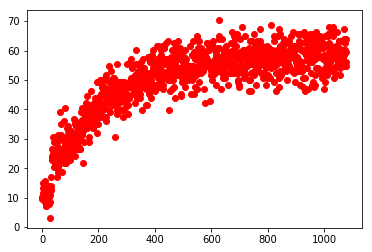

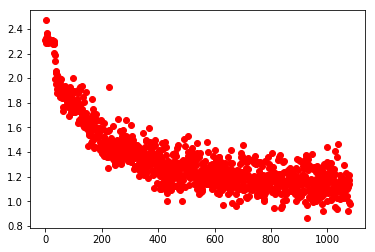

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

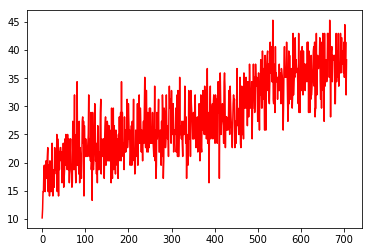

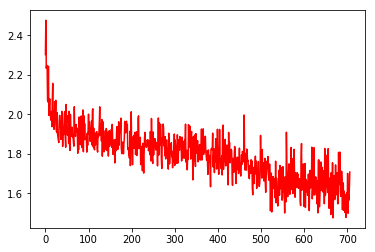

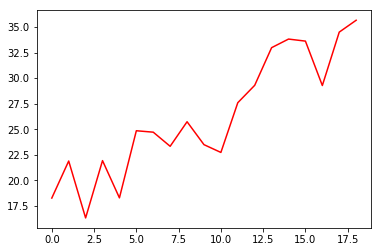

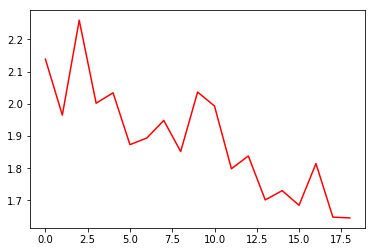

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()